### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

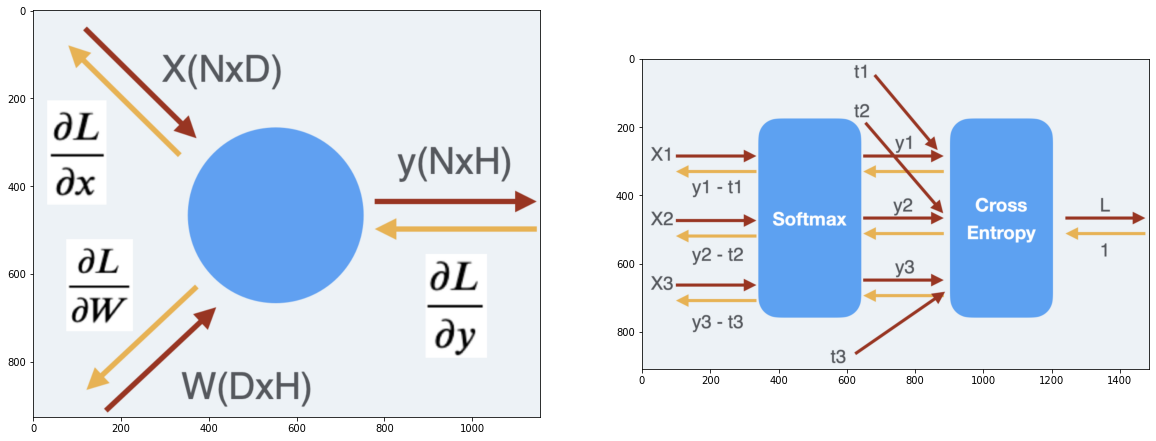

In [73]:
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
img = cv2.imread("back_prop"+".png")
img2 = cv2.imread("sc" + ".png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.rcParams['figure.figsize'] = (20,30)
plt.imshow(img2)



### Notes from reading

* Fully connected layer: $y = xW$
  * Back-Propagation (see image above): 
    * $\frac{\partial L}{\partial x} = \sum_{j}\frac{\partial L}{\partial y} W^T$
    * $\frac{\partial L}{\partial W} = X^T \sum_{j}\frac{\partial L}{\partial y}$
* Softmax and cross-entropy layer: 
  * $\text{softmax} = \frac{e^{z_{i}}}{\sum^{k}_{j}e^{z_{j}}}$
  * $\text{cross-entropy} = -\frac{1}{N}\sum^{N}_{j}\sum^{c}_{i}(\hat{y_i}logy_i)$
  * $\text{backpropagation} = \frac{\partial L}{\partial \text{Softmax In}} = \text{softmax out} - \hat{y} $






In [ ]:
# import modules
import numpy as np
from typing import List
# these utility functions are presented at the end of the notebook 
# from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
# from utils.layers import Dense, SoftmaxWithCrossEntropy
# from utils.optimizer import SGD

### code for an easy cbow model 
```python
contexts = []
    targets = corpus[window_size:-window_size]

    for idx in range(window_size, len(corpus)-window_size):
      cs = []
      for t in range(-window_size, window_size + 1):
        if t == 0:
          continue
        cs.append(corpus[idx+t])
      contexts.append(cs)
```


In [27]:
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    ###<your code>###
    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
      indices = list(range(idx - window_size, idx + window_size + 1))
      indices.remove(idx)
      ts = [corpus[i] for i in indices]
      targets.append(ts)


    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([7, 6, 3, 5, 1, 4]), array([[2, 6],
        [7, 3],
        [6, 5],
        [3, 1],
        [5, 4],
        [1, 0]]))

In [28]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]]], dtype=int32))

In [36]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])

        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [37]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size = len(word2idx), hidden_size = hidden_size, window_size = window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 18%|█▊        | 180/1000 [00:00<00:00, 899.88it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158774236603124
Epoch: 2, Iteration: 1/2, Loss: 4.158719336402039
Epoch: 3, Iteration: 1/2, Loss: 4.158802856578301
Epoch: 4, Iteration: 1/2, Loss: 4.158861769498669
Epoch: 5, Iteration: 1/2, Loss: 4.158648940157295
Epoch: 6, Iteration: 1/2, Loss: 4.158584663402897
Epoch: 7, Iteration: 1/2, Loss: 4.158575115929417
Epoch: 8, Iteration: 1/2, Loss: 4.158655950590611
Epoch: 9, Iteration: 1/2, Loss: 4.158347657570182
Epoch: 10, Iteration: 1/2, Loss: 4.15843662218556
Epoch: 11, Iteration: 1/2, Loss: 4.158627311397863
Epoch: 12, Iteration: 1/2, Loss: 4.158099805819804
Epoch: 13, Iteration: 1/2, Loss: 4.158413631769372
Epoch: 14, Iteration: 1/2, Loss: 4.158156937336127
Epoch: 15, Iteration: 1/2, Loss: 4.1581268837567436
Epoch: 16, Iteration: 1/2, Loss: 4.158027776490947
Epoch: 17, Iteration: 1/2, Loss: 4.157967523064714
Epoch: 18, Iteration: 1/2, Loss: 4.158074966766109
Epoch: 19, Iteration: 1/2, Loss: 4.15750933499714
Epoch: 20, Iteration: 1/2, Loss: 4.157793

 36%|███▌      | 362/1000 [00:00<00:00, 905.67it/s]

Epoch: 181, Iteration: 1/2, Loss: 1.4914162780003641
Epoch: 182, Iteration: 1/2, Loss: 1.493341957815035
Epoch: 183, Iteration: 1/2, Loss: 1.4898429323327202
Epoch: 184, Iteration: 1/2, Loss: 1.4974465028856134
Epoch: 185, Iteration: 1/2, Loss: 1.4713564941810497
Epoch: 186, Iteration: 1/2, Loss: 1.4849083397682046
Epoch: 187, Iteration: 1/2, Loss: 1.4817791237864784
Epoch: 188, Iteration: 1/2, Loss: 1.4977264178482281
Epoch: 189, Iteration: 1/2, Loss: 1.4644159201752303
Epoch: 190, Iteration: 1/2, Loss: 1.4780602031909464
Epoch: 191, Iteration: 1/2, Loss: 1.48476347108028
Epoch: 192, Iteration: 1/2, Loss: 1.464187512593353
Epoch: 193, Iteration: 1/2, Loss: 1.4881747781992427
Epoch: 194, Iteration: 1/2, Loss: 1.4652238377510889
Epoch: 195, Iteration: 1/2, Loss: 1.4846681261376455
Epoch: 196, Iteration: 1/2, Loss: 1.456647693930023
Epoch: 197, Iteration: 1/2, Loss: 1.4658094198269573
Epoch: 198, Iteration: 1/2, Loss: 1.4605747235498465
Epoch: 199, Iteration: 1/2, Loss: 1.470764324155951

 54%|█████▍    | 542/1000 [00:00<00:00, 867.45it/s]

Epoch: 370, Iteration: 1/2, Loss: 1.4057288567591661
Epoch: 371, Iteration: 1/2, Loss: 1.4036317076474059
Epoch: 372, Iteration: 1/2, Loss: 1.403027494222231
Epoch: 373, Iteration: 1/2, Loss: 1.403680495575727
Epoch: 374, Iteration: 1/2, Loss: 1.4052465178763085
Epoch: 375, Iteration: 1/2, Loss: 1.402977023517495
Epoch: 376, Iteration: 1/2, Loss: 1.4030879207290423
Epoch: 377, Iteration: 1/2, Loss: 1.4056011218303652
Epoch: 378, Iteration: 1/2, Loss: 1.402450767239757
Epoch: 379, Iteration: 1/2, Loss: 1.4015264960968188
Epoch: 380, Iteration: 1/2, Loss: 1.404905862224203
Epoch: 381, Iteration: 1/2, Loss: 1.4028759435391733
Epoch: 382, Iteration: 1/2, Loss: 1.4023545721126425
Epoch: 383, Iteration: 1/2, Loss: 1.4039516924161832
Epoch: 384, Iteration: 1/2, Loss: 1.4049875914228513
Epoch: 385, Iteration: 1/2, Loss: 1.4029148544196985
Epoch: 386, Iteration: 1/2, Loss: 1.4010842431551878
Epoch: 387, Iteration: 1/2, Loss: 1.4025526059876139
Epoch: 388, Iteration: 1/2, Loss: 1.404571438529996

 72%|███████▏  | 718/1000 [00:00<00:00, 841.91it/s]

Epoch: 543, Iteration: 1/2, Loss: 1.3970520222233782
Epoch: 544, Iteration: 1/2, Loss: 1.3954031678735606
Epoch: 545, Iteration: 1/2, Loss: 1.3955361360294032
Epoch: 546, Iteration: 1/2, Loss: 1.39455567344246
Epoch: 547, Iteration: 1/2, Loss: 1.3963941223463245
Epoch: 548, Iteration: 1/2, Loss: 1.394682215878026
Epoch: 549, Iteration: 1/2, Loss: 1.3951483031311578
Epoch: 550, Iteration: 1/2, Loss: 1.3954893497369483
Epoch: 551, Iteration: 1/2, Loss: 1.3954259051195326
Epoch: 552, Iteration: 1/2, Loss: 1.3946754803672394
Epoch: 553, Iteration: 1/2, Loss: 1.3952789825505922
Epoch: 554, Iteration: 1/2, Loss: 1.3957774311495845
Epoch: 555, Iteration: 1/2, Loss: 1.3952172474896625
Epoch: 556, Iteration: 1/2, Loss: 1.3945180694000723
Epoch: 557, Iteration: 1/2, Loss: 1.3958621529782014
Epoch: 558, Iteration: 1/2, Loss: 1.395079654504187
Epoch: 559, Iteration: 1/2, Loss: 1.3951905632472057
Epoch: 560, Iteration: 1/2, Loss: 1.3952807149917534
Epoch: 561, Iteration: 1/2, Loss: 1.39488501700674

 90%|████████▉ | 896/1000 [00:01<00:00, 864.51it/s]

Epoch: 720, Iteration: 1/2, Loss: 1.391582983284304
Epoch: 721, Iteration: 1/2, Loss: 1.3927367964871034
Epoch: 722, Iteration: 1/2, Loss: 1.3922621542826574
Epoch: 723, Iteration: 1/2, Loss: 1.3920981302331514
Epoch: 724, Iteration: 1/2, Loss: 1.3921735522766614
Epoch: 725, Iteration: 1/2, Loss: 1.3923579189824606
Epoch: 726, Iteration: 1/2, Loss: 1.3925382892015827
Epoch: 727, Iteration: 1/2, Loss: 1.3918132509661505
Epoch: 728, Iteration: 1/2, Loss: 1.3917372388192848
Epoch: 729, Iteration: 1/2, Loss: 1.3922454221693017
Epoch: 730, Iteration: 1/2, Loss: 1.3925534160903532
Epoch: 731, Iteration: 1/2, Loss: 1.3917715879730077
Epoch: 732, Iteration: 1/2, Loss: 1.392528781704046
Epoch: 733, Iteration: 1/2, Loss: 1.392127630725899
Epoch: 734, Iteration: 1/2, Loss: 1.3921195268230744
Epoch: 735, Iteration: 1/2, Loss: 1.3921277376074062
Epoch: 736, Iteration: 1/2, Loss: 1.3925423651196345
Epoch: 737, Iteration: 1/2, Loss: 1.391766501571405
Epoch: 738, Iteration: 1/2, Loss: 1.39192970814900

100%|██████████| 1000/1000 [00:01<00:00, 860.06it/s]

Epoch: 905, Iteration: 1/2, Loss: 1.3908924609661402
Epoch: 906, Iteration: 1/2, Loss: 1.3906930318518094
Epoch: 907, Iteration: 1/2, Loss: 1.3902718585750837
Epoch: 908, Iteration: 1/2, Loss: 1.39083579020944
Epoch: 909, Iteration: 1/2, Loss: 1.3906480303409765
Epoch: 910, Iteration: 1/2, Loss: 1.3905720806931758
Epoch: 911, Iteration: 1/2, Loss: 1.3904719261441842
Epoch: 912, Iteration: 1/2, Loss: 1.3907033769828947
Epoch: 913, Iteration: 1/2, Loss: 1.390538622223936
Epoch: 914, Iteration: 1/2, Loss: 1.3901321845387753
Epoch: 915, Iteration: 1/2, Loss: 1.3909659201105316
Epoch: 916, Iteration: 1/2, Loss: 1.3903752146591493
Epoch: 917, Iteration: 1/2, Loss: 1.3905860969183603
Epoch: 918, Iteration: 1/2, Loss: 1.3902386080170068
Epoch: 919, Iteration: 1/2, Loss: 1.3904682605369332
Epoch: 920, Iteration: 1/2, Loss: 1.3905529413258353
Epoch: 921, Iteration: 1/2, Loss: 1.3907583169963758
Epoch: 922, Iteration: 1/2, Loss: 1.3905170972869656
Epoch: 923, Iteration: 1/2, Loss: 1.3904649012997

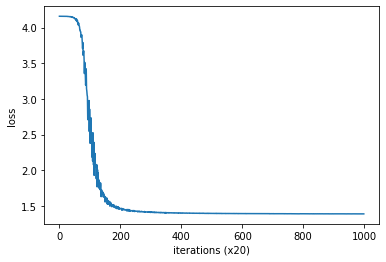

In [38]:
trainer.plot()

In [65]:
# check skip-gram results
wordvector = skip_gram.word_vecs
print(repr("word").ljust(15),"|",repr("word vector").ljust(55), "\n", "="*120)
for word_id, word in idx2word.items():
    print(repr(word).ljust(15),"|",repr(np.round_(wordvector[word_id], decimals = 5)))

'word'          | 'word vector'                                           
'.'             | array([-0.00359,  0.01982, -0.00676, -0.00394,  0.00438], dtype=float32)
'processing'    | array([ 0.79493,  1.26511, -1.62673,  1.71633, -0.16949], dtype=float32)
'i'             | array([-0.00881,  0.00164, -0.00463, -0.00151, -0.01599], dtype=float32)
'natural'       | array([-0.08459, -1.33209, -0.18731,  2.72282, -0.6919 ], dtype=float32)
'now'           | array([-2.62005,  0.91158,  0.58707,  0.04877, -0.38772], dtype=float32)
'language'      | array([-0.88854,  1.91618,  0.43903, -2.14049,  0.87124], dtype=float32)
'studying'      | array([ 1.90517,  0.48728,  0.36777, -2.04248,  0.10768], dtype=float32)
'am'            | array([-0.1442 , -2.73852,  0.63373,  0.00693,  0.23733], dtype=float32)


In [43]:
wordvector[1]

array([ 0.7949312 ,  1.2651135 , -1.6267284 ,  1.716333  , -0.16949391],
      dtype=float32)

In [19]:
### Utility function
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from typing import List

# define softmax function
def softmax(x):
    if x.ndim == 2:
        x = np.exp(x)
        x = np.divide(x, x.sum(axis=1, keepdims=True) + 1e-7)
    elif x.ndim == 1:
        x = np.exp(x)
        x = np.divide(x, np.sum(x) + 1e-7)
        
    return x

# define cross entropy
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]
    
    return -(1/batch_size) * np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))

# Define FC layer
class Dense():
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        w = self.params[0]
        out = np.dot(x, w)
        self.x = x
        
        return out
    
    def backward(self, dout):
        w = self.params[0]
        dx = np.dot(dout, w.T) #dx = dy * W^T
        dw = np.dot(self.x.T, dout) #dw = x^T * dx
        self.grads[0][...] = dw
        
        return dx
    
# define softmax with cross entropy layer
class SoftmaxWithCrossEntropy:
    def __init__(self):
        self.t = None
        self.y = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        
        loss = cross_entropy(self.y, self.t)
        
        return loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        dx = self.y.copy() #softmax output
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size
        
        return dx
def remove_duplicate(params, grads):

    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # duplicate weights
                if params[i] is params[j]:
                    grads[i] += grads[j]  
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


#define preprocess function
def preprocess(corpus: List[str], only_word: bool = False):
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    '''
    word_dic = set()
    processed_sentence = []
    
    for sentence in corpus:
        #將所有字詞轉為小寫
        sentence = sentence.lower()

        #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
        if only_word:
            pattern = r'[^\W_]+'
            sentence = re.findall(pattern, sentence)
        else:
            punctuation_list = ['.', ',', '!', '?']
            for pun in punctuation_list:
                sentence = sentence.replace(pun, ' '+pun)
            sentence = sentence.split(' ')
        
        #添加字詞到字典中
        word_dic |= set(sentence)
        processed_sentence.append(sentence)
    
    
    #建立字詞ID清單
    word2idx = dict()
    idx2word = dict()
    for word in word_dic:
        if word not in word2idx:
            idx = len(word2idx)
            word2idx[word] = idx
            idx2word[idx] = word

    #將文本轉為ID型式
    id_mapping = lambda x: word2idx[x]
    
    corpus = np.array([list(map(id_mapping, sentence)) for sentence in processed_sentence])

    return corpus, word2idx, idx2word


# define function to create contexts - target
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = []
    targets = corpus[window_size:-window_size]

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(targets)


def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


# define trainer for training purpose
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        for epoch in tqdm.tqdm(range(max_epoch)):
            # shuffling
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # calculate loss and update weights
                loss = model.forward(batch_x, batch_t)
                model.backward()
                # remove duplicate weights (for weights sharing purpose)
                params, grads = remove_duplicate(model.params, model.grads) 
                # for gradient clipping purpose
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                    
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # evaluation
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    print(f"Epoch: {self.current_epoch+1}, Iteration: {iters+1}/{max_iters}, Loss: {avg_loss}")
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = list(range(len(self.loss_list)))
        
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel(f"iterations (x{self.eval_interval})")
        plt.ylabel(f"loss")
        plt.show()
class SGD:
    '''
    Stochastic Gradient Descent
    '''
    def __init__(self, lr=0.1):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]